>[Load Data](#scrollTo=NUI5kbcWownP)

>[Preprocessing](#scrollTo=GF3n7POppx8u)

>>[Create same size slices](#scrollTo=kC6RHcbEvfGi)

>>[Transform images](#scrollTo=fvjy5Nchv6AA)

>[Train images](#scrollTo=RwFDZ-rn-JCy)

>>[Functions for training](#scrollTo=76WXT37uBUSk)

>>[Training](#scrollTo=WIyDq5MmBjKU)

>>[Unet 3+](#scrollTo=-5K7WElk4Mkw)

>[Testing](#scrollTo=ZDtWeaxR1rpV)



In [ ]:
!git clone https://github.com/rcuocolo/PROSTATEx_masks

Cloning into 'PROSTATEx_masks'...
remote: Enumerating objects: 5026, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 5026 (delta 353), reused 195 (delta 179), pack-reused 4650
Receiving objects: 100% (5026/5026), 902.72 MiB | 20.86 MiB/s, done.
Resolving deltas: 100% (3701/3701), done.
Checking out files: 100% (2565/2565), done.


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#for colab
%cd "/content/drive/MyDrive/Prostate"

/content/drive/MyDrive/Prostate


In [1]:
!pip install dicom2nifti

  Using cached dicom2nifti-2.4.8-py3-none-any.whl (43 kB)
  Using cached python_gdcm-3.0.21-cp310-cp310-win_amd64.whl (27.2 MB)
  Using cached nibabel-5.0.1-py3-none-any.whl (3.3 MB)
  Using cached scipy-1.10.1-cp310-cp310-win_amd64.whl (42.5 MB)
  Using cached pydicom-2.3.1-py3-none-any.whl (2.0 MB)


You should consider upgrading via the 'C:\Users\envy\Desktop\Prostate_MRI\-Prostate_MRI_Detection_3D_Model\packages\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install monai

  Using cached monai-1.1.0-202212191849-py3-none-any.whl (1.2 MB)


You should consider upgrading via the 'C:\Users\envy\Desktop\Prostate_MRI\-Prostate_MRI_Detection_3D_Model\packages\Scripts\python.exe -m pip install --upgrade pip' command.


## Initial

In [2]:
HOME_DIR =       "./"
DATA_DIR =       "./PROSTATEx_masks/Files/prostate/"
OUT_DIR =        "./results/"
SLICED_OUT_DIR = "./data/sliced/prostate/"
AUG_OUT_DIR = "./data/augmented/prostate/"

In [16]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
import pandas as pd
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    SqueezeDimd,
    ResizeWithPadOrCrop,
    

)
from monai.data import DataLoader, Dataset
from monai.utils import first

import json
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os

In [4]:
df = pd.read_csv(DATA_DIR +'image_list.csv')

In [7]:
# ignore
df.head()

,T2
0,ProstateX-0000_t2_tse_tra_4
1,ProstateX-0001_t2_tse_tra_10
2,ProstateX-0002_t2_tse_tra_4
3,ProstateX-0003_t2_tse_tra_3
4,ProstateX-0004_t2_tse_tra_5


In [5]:
def makeLabelNo(name):
  numb= name.split("-")[1]
  li=[80,81,83,85,86,87,88,89,90,91,93,96,98,125,127]
  if(int(numb) in li):
    return 'ProstateX-' + numb[1:]
  return name

In [6]:
data = [{'image': DATA_DIR + 'Images/' + x + ".nii.gz", "label":DATA_DIR + 'mask_prostate/' + makeLabelNo(x.split("_")[0]) + ".nii.gz"  } for x in df['T2']]

In [7]:
# ignore
l=[]
for i in data:
  image = nib.load(i["image"])
  # label = nib.load(i["label"])
  # print(image.shape, label.shape)
  l.append(image.shape[2])
print(min(l),max(l))

18 27


# Preprocessing

## Create same size slices
create new nifti images with 18 slices and save 

In [8]:
def load_nifti(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = nib.load(image_nifty_file)
    label = nib.load(label_nifty_file)
    
    return image, label

In [10]:
def save_to_json(data, path):
  with open(path, 'w') as fp:
    json.dump(data, fp)

## Create 3D slices

In [14]:
slice_size=16

In [15]:
# create directries if does not exist
if not os.path.exists(SLICED_OUT_DIR):
    os.makedirs(SLICED_OUT_DIR)
if not os.path.exists(SLICED_OUT_DIR + "Images"):
    os.makedirs(SLICED_OUT_DIR + "Images")
if not os.path.exists(SLICED_OUT_DIR + "mask_prostate"):
    os.makedirs(SLICED_OUT_DIR + "mask_prostate")

In [16]:
def remove_slices(img,start, end):
  imgvol = np.array( img.dataobj );
  imgvol = imgvol[ :, :, start:end ];
  newimg = nib.Nifti1Image ( imgvol, img.affine );
  return newimg

In [18]:
def create_same_slice_nifti(data):
  paths = []
  total = len(data)
  count = 1
  for entry in data:
    img, lbl = load_nifti(entry["image"], entry["label"])

    total_slize_size =img.shape[2]
    if(total_slize_size < slice_size): print("ERROR: slice upper limit exceeds")
    extra_slices = total_slize_size - slice_size
    end  = total_slize_size - (extra_slices // 2 )
    start = end - slice_size 

    newimg = remove_slices(img,start, end)
    newlbl = remove_slices(lbl,start, end)
    image_path = entry["image"].replace('PROSTATEx_masks/Files', "data/sliced")
    label_path = entry["label"].replace('PROSTATEx_masks/Files', "data/sliced")
    paths.append({"image":image_path, "label":label_path})
    newimg.to_filename(image_path );
    newlbl.to_filename(label_path);
    
    print(f"{count}/{total}")
    count += 1

  save_to_json({"path": paths}, SLICED_OUT_DIR + 'config.json')

In [19]:
create_same_slice_nifti(data)

1/204
2/204
3/204
4/204
5/204
6/204
7/204
8/204
9/204
10/204
11/204
12/204
13/204
14/204
15/204
16/204
17/204
18/204
19/204
20/204
21/204
22/204
23/204
24/204
25/204
26/204
27/204
28/204
29/204
30/204
31/204
32/204
33/204
34/204
35/204
36/204
37/204
38/204
39/204
40/204
41/204
42/204
43/204
44/204
45/204
46/204
47/204
48/204
49/204
50/204
51/204
52/204
53/204
54/204
55/204
56/204
57/204
58/204
59/204
60/204
61/204
62/204
63/204
64/204
65/204
66/204
67/204
68/204
69/204
70/204
71/204
72/204
73/204
74/204
75/204
76/204
77/204
78/204
79/204
80/204
81/204
82/204
83/204
84/204
85/204
86/204
87/204
88/204
89/204
90/204
91/204
92/204
93/204
94/204
95/204
96/204
97/204
98/204
99/204
100/204
101/204
102/204
103/204
104/204
105/204
106/204
107/204
108/204
109/204
110/204
111/204
112/204
113/204
114/204
115/204
116/204
117/204
118/204
119/204
120/204
121/204
122/204
123/204
124/204
125/204
126/204
127/204
128/204
129/204
130/204
131/204
132/204
133/204
134/204
135/204
136/204
137/204
138/204
139/

# Augmentation

In [20]:
def get_data_path(path):
  f = open( path + 'config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [21]:
data = get_data_path(SLICED_OUT_DIR)

In [22]:
from Augmentation.augmentation import verticalFlip, horizontalFlip, rotate, noise, elasticDeformation


types = { 'verticalFliped': verticalFlip, 'horizontalFliped' : horizontalFlip, 'rotated':rotate, 'noised':noise, 'deformed': elasticDeformation}

for type,func in types.items():
    # create directries if does not exist
    if not os.path.exists(AUG_OUT_DIR + type ):
        os.makedirs(AUG_OUT_DIR + type)
    if not os.path.exists(AUG_OUT_DIR + type + "/Images"):
        os.makedirs(AUG_OUT_DIR + type + "/Images")
    if not os.path.exists(AUG_OUT_DIR + type + "/mask_prostate"):
        os.makedirs(AUG_OUT_DIR + type + "/mask_prostate")

In [23]:
def augment(func, entry, name, paths):
    img, lbl = load_nifti(entry["image"], entry["label"])
    
    image, label = func(img, lbl)
    image_path = entry["image"].replace("data/sliced/prostate", "data/augmented/prostate/" + name)
    label_path = entry["label"].replace("data/sliced/prostate", "data/augmented/prostate/" + name)
    paths.append({"image":image_path, "label":label_path})
    image.to_filename(image_path )
    label.to_filename(label_path)
    

In [24]:

paths = []
for type, func in types.items():
    #create augmented data
    
    for entry in data:
        augment(func, entry, type, paths)
        break
   
save_to_json({"path": paths}, AUG_OUT_DIR + '/config.json')    


In [25]:
# x = data + paths
# len(x)

209

## Check

In [97]:
# first image, label from orignal image
imagea =nib.load(data[0]["image"]).get_fdata()
labela =nib.load(data[0]["label"]).get_fdata()
print(imagea.shape,labela.shape)

(384, 384, 16) (384, 384, 16)


In [117]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(imagea[:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off')

    ax[1].imshow(labela[:,:,layer])
    ax[1].axis('off')
    return layer

In [118]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 16));

interactive(children=(IntSlider(value=8, description='layer', max=16), Output()), _dom_classes=('widget-intera…

In [98]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 18));

interactive(children=(IntSlider(value=9, description='layer', max=18), Output()), _dom_classes=('widget-intera…

## Transform images

In [17]:
def get_data_path(path):
  f = open( path + 'config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [18]:
data = get_data_path(SLICED_OUT_DIR)

In [19]:
data = get_data_path(SLICED_OUT_DIR)
aug_data = get_data_path(AUG_OUT_DIR)
data = data + aug_data
train_size = int(0.8 * len(data))
train_data, test_data = data[:train_size], data[train_size:]

In [20]:
pixdim =(1.5, 1.5, 1.0)
a_min=0
a_max=500
spatial_size= [128, 128,16] #[384, 384,18]


In [21]:
import torch

def extract_slice(img, index):
    print(img.shape)
    print(img[ :, :,:, index])
    return img[ :, :,:, index]

In [23]:
from torchvision.transforms import Lambda

train_transforms = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          # Spacingd(keys=["image", "label"], pixdim=pixdim, mode=("bilinear", "nearest")), # not clear
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
          CropForegroundd(keys=["image", "label"], source_key="image"),
          Resized(keys=["image", "label"], spatial_size=spatial_size),
          #Lambda(lambda data: {"image": extract_slice(data["image"], 15), "label": extract_slice(data["label"], 15)}),
          #CenterCropOrPad(keys=["image", "label"], spatial_size=central_slice_size),
          #ResizeWithPadOrCrop(keys=["image", "label"], spatial_size=central_slice_size),
          #SqueezeDimd(keys=["image", "label"],dim=-1),
          ToTensord(keys=["image", "label"])

      ]
  )

test_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            # Spacingd(keys=["image", "label"], pixdim=pixdim, mode=("bilinear", "nearest")), # not clear
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["image", "label"], source_key="image"),
            Resized(keys=["image", "label"], spatial_size=spatial_size),
            #Lambda(lambda data: {"image": extract_slice(data["image"], 15), "label": extract_slice(data["label"], 15)}),
            #ResizeWithPadOrCrop(keys=["image", "label"], spatial_size=central_slice_size),
            #SqueezeDimd(keys=["image", "label"],dim=-1),
            ToTensord(keys=["image", "label"])
            
        ]
    )

In [24]:
train_ds = Dataset(data=train_data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

In [25]:
test_ds = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [26]:
# first image, label from orignal image
imagea =nib.load(data[0]["image"]).get_fdata()
labela =nib.load(data[0]["label"]).get_fdata()
print(imagea.shape,labela.shape)

(384, 384, 16) (384, 384, 16)


In [27]:
# first image, label from preprossed image
image1= first(train_loader)["image"]
label1 = first(train_loader)["label"]
print(image1.shape,label1.shape)
image11 =image1.get_array()
label11 = label1.get_array()

torch.Size([1, 1, 128, 128, 16]) torch.Size([1, 1, 128, 128, 16])


In [28]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(imagea[:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off');

    ax[1].imshow(labela[:,:,layer])
    ax[1].axis('off');
    return layer

In [29]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 18))

interactive(children=(IntSlider(value=9, description='layer', max=18), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage(layer)>

In [30]:
# Define a function to visualize the data
def explore_3dimage2(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(image1[0,0,:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off');

    ax[1].imshow(label1[0,0,:,:,layer])
    ax[1].axis('off');
    return 

In [31]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 16))

interactive(children=(IntSlider(value=8, description='layer', max=16), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage(layer)>

# Train images

## Functions for training

In [32]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

In [33]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [34]:
def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

In [35]:
def load_metrices(path):
  metrices_dir = path
  #if n : metrices_dir = OUT_DIR + 'tries/try' + str(n) + "/"
  train_loss = np.load(os.path.join(metrices_dir, 'loss_train.npy'))
  train_metric = np.load(os.path.join(metrices_dir, 'metric_train.npy'))
  test_loss = np.load(os.path.join(metrices_dir, 'loss_test.npy'))
  test_metric = np.load(os.path.join(metrices_dir, 'metric_test.npy'))
  return train_loss, train_metric, test_loss, test_metric

In [36]:
import datetime
import pytz

def get_time():
  utc_time= datetime.datetime.now(pytz.utc)
  local_time = utc_time.astimezone(pytz.timezone('Asia/Colombo'))
  return local_time.strftime("%Y:%m:%d %H:%M:%S")

def update_history(data,model_dir):
  history_file_path = model_dir + "history.csv"
  if not os.path.exists(history_file_path):
    with open(history_file_path,'a') as fd:
        fd.write(",".join(["Start", "End", "Best Matrix", "Best M. At", "Time Taken", "CUDA Memory Used", "CPU Memory","Time"]))
  with open(history_file_path,'a') as fd:
      str_data=[str(x) for x in (data + [get_time()])]
      fd.write("\n" + ",".join(str_data))

In [37]:
import torch
import torchvision
import time
import psutil

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0"), start_from=1):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    if (start_from != 1):
      save_loss_train, save_metric_train, save_loss_test, save_metric_test= [x.tolist() for x in load_metrices()]
      best_metric = max(save_metric_train)
      best_metric_epoch = -2
    train_loader, test_loader = data_in

   
    start = time.time()

    for epoch in range(start_from -1 , max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["image"]
            label = batch_data["label"]
            label = label != 0

            if torch.cuda.is_available():
              volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            print("shape", volume.shape)
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}", end=" ")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1
                    print(test_step)

                    test_volume = test_data["image"]
                    test_label = test_data["label"]
                    test_label = test_label != 0
                    if torch.cuda.is_available():
                      test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    print(test_volume.shape)
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                print(test_step)
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

            end = time.time()
            time_taken = end - start
            cuda_memory = round(torch.cuda.memory_allocated(device=device) / (1024*1024) ,2 )
            cpu_memory = round(psutil.Process().memory_info().rss / (1024*1024),2 )
            print(time_taken)
            print(cuda_memory)
            print(cpu_memory)
            print(
                f"train completed, best_metric: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")
            update_history([start_from, max_epochs, best_metric, best_metric_epoch, time_taken, cuda_memory, cpu_memory],model_dir=model_dir)


  

In [143]:
import psutil

psutil.Process().memory_info().rss / (1024*1024) 

466.75390625

# Training

In [38]:
#from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch

In [39]:
model_dir = OUT_DIR 
data_in = [train_loader, test_loader]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## UNet

In [40]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

unet = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [88]:
def test():
    image1 = torch.randn((1, 1, 128, 128,16))
    preds = unet(image1)
    print(sum(p.numel() for p in unet.parameters()))
    
    
#check wheather model works
test()

4808917


In [79]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(unet.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [81]:
model_dir = OUT_DIR + "/unet/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [82]:
import os.path

path = OUT_DIR+ "unet/"+ "best_metric_model.pth"

if (os.path.exists(path)):
    unet.load_state_dict(torch.load(
        os.path.join(path)))

In [86]:
train(unet, data_in, loss_function, optimizer, 2, model_dir, test_interval=1,start_from=1,model_name='unet')

----------
epoch 1/2
shape torch.Size([1, 1, 128, 128, 16])
1/167, Train_loss: 0.4855 Train_dice: 0.5145
shape torch.Size([1, 1, 128, 128, 16])
2/167, Train_loss: 0.5030 Train_dice: 0.4970
shape torch.Size([1, 1, 128, 128, 16])
3/167, Train_loss: 0.5111 Train_dice: 0.4889
shape torch.Size([1, 1, 128, 128, 16])
4/167, Train_loss: 0.3863 Train_dice: 0.6137
shape torch.Size([1, 1, 128, 128, 16])
5/167, Train_loss: 0.4091 Train_dice: 0.5909
shape torch.Size([1, 1, 128, 128, 16])
6/167, Train_loss: 0.4952 Train_dice: 0.5048
shape torch.Size([1, 1, 128, 128, 16])
7/167, Train_loss: 0.4550 Train_dice: 0.5450
shape torch.Size([1, 1, 128, 128, 16])
8/167, Train_loss: 0.4308 Train_dice: 0.5692
shape torch.Size([1, 1, 128, 128, 16])
9/167, Train_loss: 0.4638 Train_dice: 0.5362
shape torch.Size([1, 1, 128, 128, 16])
10/167, Train_loss: 0.4427 Train_dice: 0.5573
shape torch.Size([1, 1, 128, 128, 16])
11/167, Train_loss: 0.4982 Train_dice: 0.5018
shape torch.Size([1, 1, 128, 128, 16])
12/167, Train_

## Unet 3+

In [89]:
from Models.Unet_TriplePlus import U_net_TriplePlus

In [96]:
unet_3plus =  U_net_TriplePlus(1,1).to(device)


In [97]:
def test():
    image1 = torch.randn((1, 1, 128, 128,16))
    preds = unet_3plus(image1)
    print(sum(p.numel() for p in unet_3plus.parameters()))
    
    
#check wheather model works
test()

6688497


In [98]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(unet_3plus.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [99]:
model_dir = OUT_DIR + "/unet_3plus/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [101]:
import os.path

path = OUT_DIR+ "unet_3plus/"+ "best_metric_model.pth"
print(path)
if (os.path.exists(path)):
    unet.load_state_dict(torch.load(
        os.path.join(path)))

./results/unet_3plus/best_metric_model.pth


In [103]:
train(unet_3plus, data_in, loss_function, optimizer, 2, model_dir, test_interval=1,start_from=1)

----------
epoch 1/2
shape torch.Size([1, 1, 128, 128, 16])


c:\Users\envy\Desktop\Prostate_MRI\-Prostate_MRI_Detection_3D_Model\packages\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/167, Train_loss: 0.8627 Train_dice: 0.1373
shape torch.Size([1, 1, 128, 128, 16])
2/167, Train_loss: 0.9036 Train_dice: 0.0964
shape torch.Size([1, 1, 128, 128, 16])
3/167, Train_loss: 0.8710 Train_dice: 0.1290
shape torch.Size([1, 1, 128, 128, 16])
4/167, Train_loss: 0.7247 Train_dice: 0.2753
shape torch.Size([1, 1, 128, 128, 16])
5/167, Train_loss: 0.6856 Train_dice: 0.3144
shape torch.Size([1, 1, 128, 128, 16])
6/167, Train_loss: 0.8063 Train_dice: 0.1937
shape torch.Size([1, 1, 128, 128, 16])
7/167, Train_loss: 0.7579 Train_dice: 0.2421
shape torch.Size([1, 1, 128, 128, 16])
8/167, Train_loss: 0.7465 Train_dice: 0.2535
shape torch.Size([1, 1, 128, 128, 16])
9/167, Train_loss: 0.7536 Train_dice: 0.2464
shape torch.Size([1, 1, 128, 128, 16])
10/167, Train_loss: 0.7331 Train_dice: 0.2669
shape torch.Size([1, 1, 128, 128, 16])
11/167, Train_loss: 0.8192 Train_dice: 0.1808
shape torch.Size([1, 1, 128, 128, 16])
12/167, Train_loss: 0.8752 Train_dice: 0.1248
shape torch.Size([1, 1, 128,

KeyboardInterrupt: 

# ModifiedNet


In [41]:
from Models.ModifiedNet import MNet

mnet = MNet().to(device)


In [42]:
def test():
    image1 = torch.randn((1, 1, 128, 128,16))
    preds = mnet(image1)
    print(sum(p.numel() for p in mnet.parameters()))
    
    
#check wheather model works
test()

torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])
43247617


In [43]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(mnet.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [44]:
model_dir = OUT_DIR + "mnet/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [45]:
import os.path

path = OUT_DIR+ "mnet/"+ "best_metric_model.pth"
print(path)
if (os.path.exists(path)):
    unet.load_state_dict(torch.load(
        os.path.join(OUT_DIR+ "mnet"+ "best_metric_model.pth")))

./results/mnet/best_metric_model.pth


In [46]:
train(mnet, data_in, loss_function, optimizer, 2, model_dir, test_interval=1,start_from=1)

----------
epoch 1/2
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])


c:\Users\envy\Desktop\Prostate_MRI\Prostate_MRI_Detection_3D_Model\packages\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/167, Train_loss: 0.8946 Train_dice: 0.1054
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])


KeyboardInterrupt: 

# Testing

In [47]:
from monai.utils import first
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [48]:
path = OUT_DIR+ "unet/"
train_loss, train_metric, test_loss, test_metric= load_metrices(path)

In [49]:
def plt_metrices(train_loss, train_metric, test_loss, test_metric):
  plt.figure("Results 25 june", (12, 6))
  plt.subplot(2, 2, 1)
  plt.title("Train dice loss")
  x = [i + 1 for i in range(len(train_loss))]
  y = train_loss
  plt.xlabel("epoch")
  plt.plot(x, y)

  plt.subplot(2, 2, 2)
  plt.title("Train metric DICE")
  x = [i + 1 for i in range(len(train_metric))]
  y = train_metric
  plt.xlabel("epoch")
  plt.plot(x, y)

  plt.subplot(2, 2, 3)
  plt.title("Test dice loss")
  x = [i + 1 for i in range(len(test_loss))]
  y = test_loss
  plt.xlabel("epoch")
  plt.plot(x, y)

  plt.subplot(2, 2, 4)
  plt.title("Test metric DICE")
  x = [i + 1 for i in range(len(test_metric))]
  y = test_metric
  plt.xlabel("epoch")
  plt.plot(x, y)

  plt.show()

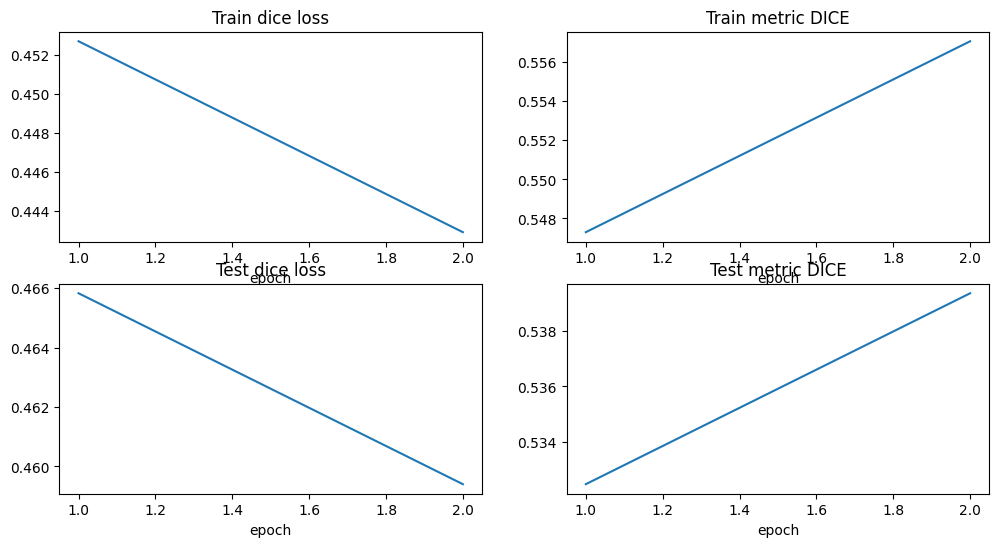

In [50]:
plt_metrices(train_loss, train_metric, test_loss, test_metric)

In [52]:

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [53]:
import os.path

path = OUT_DIR+ "unet/"+ "best_metric_model.pth"

if (os.path.exists(path)):
    model.load_state_dict(torch.load(
        os.path.join(path)))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


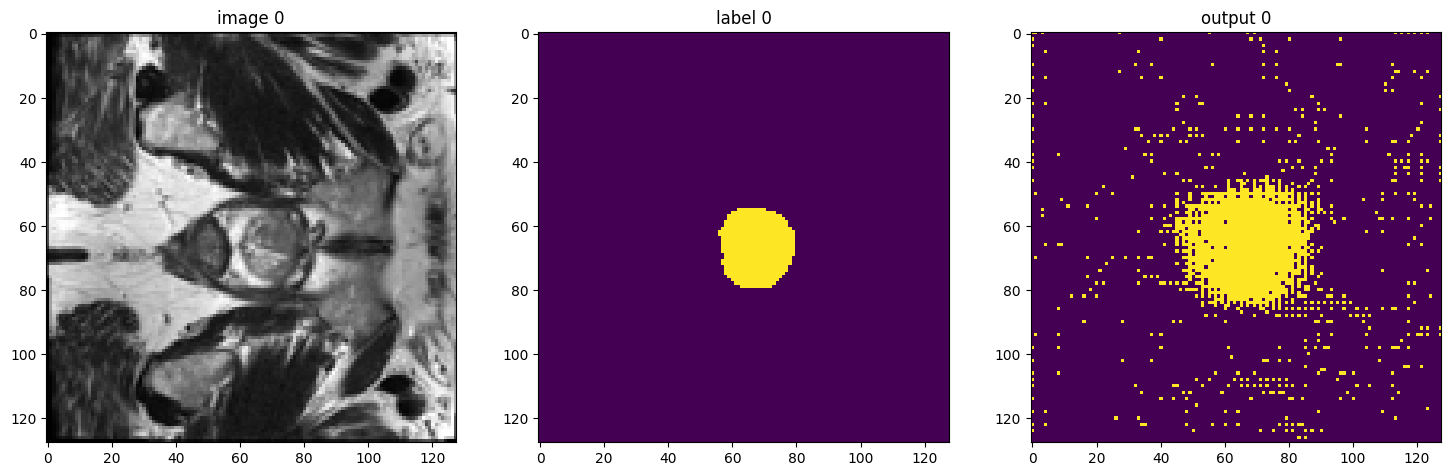

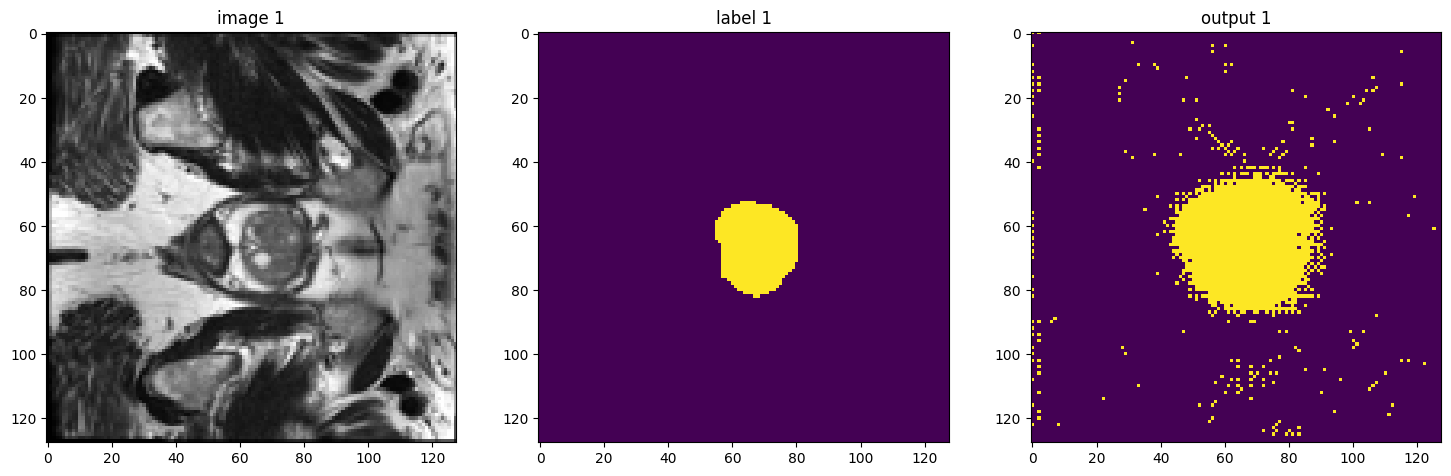

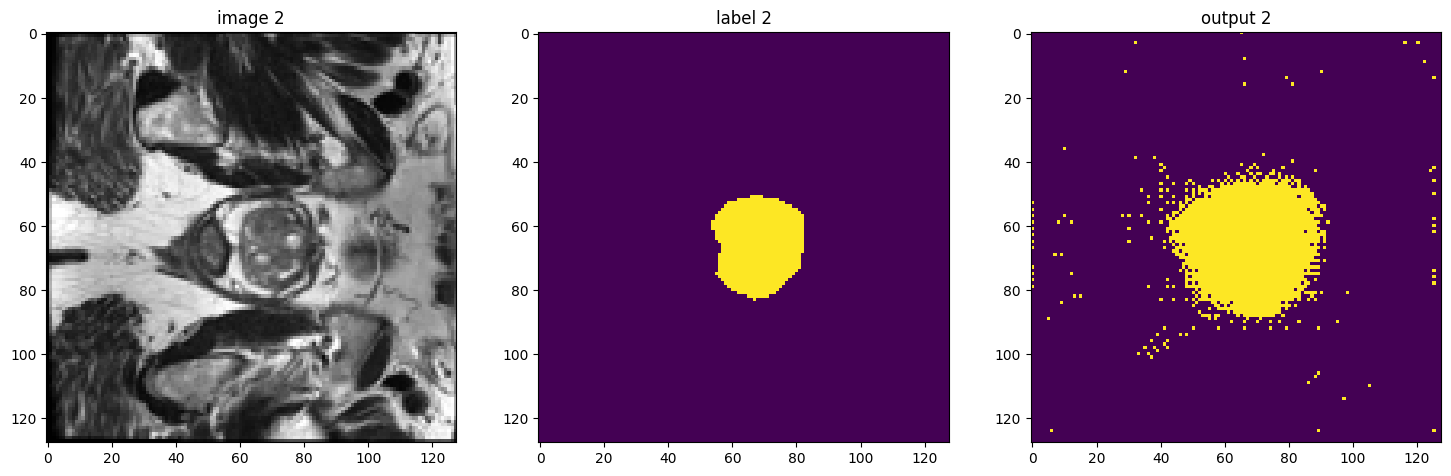

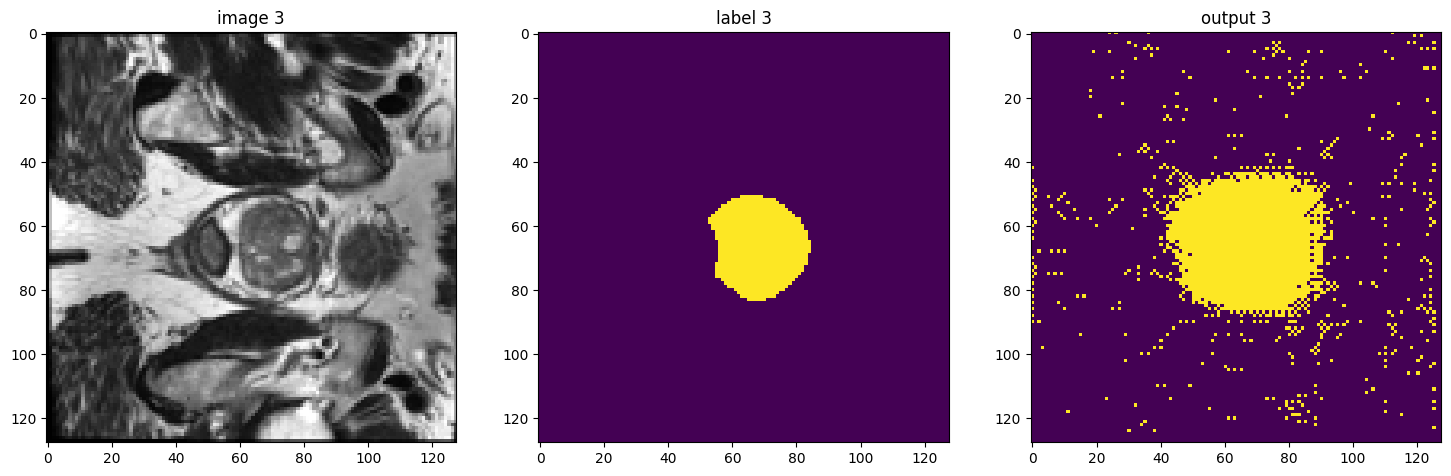

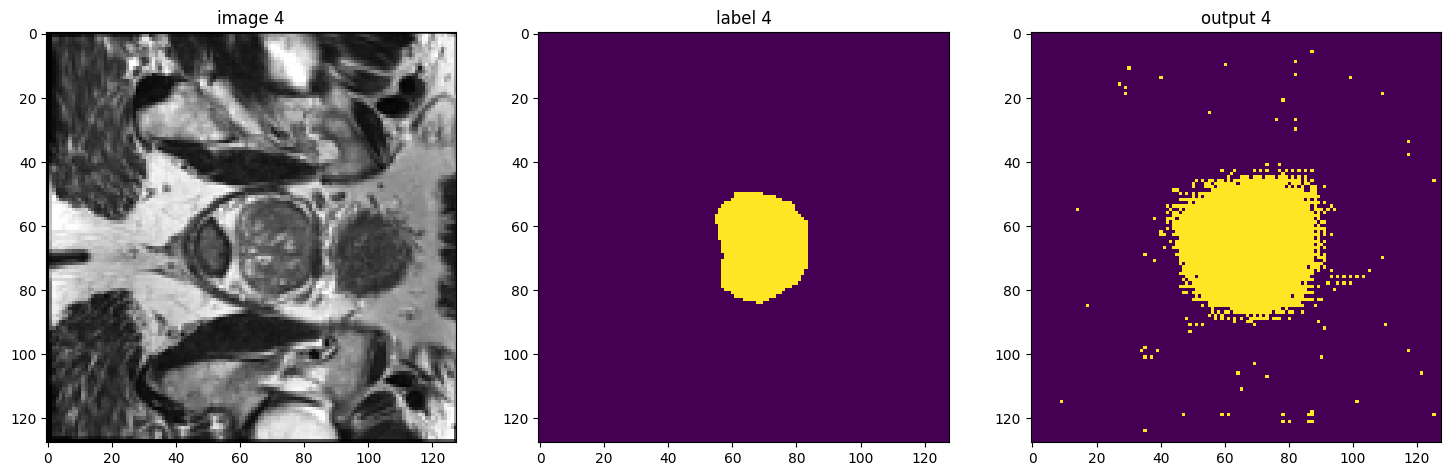

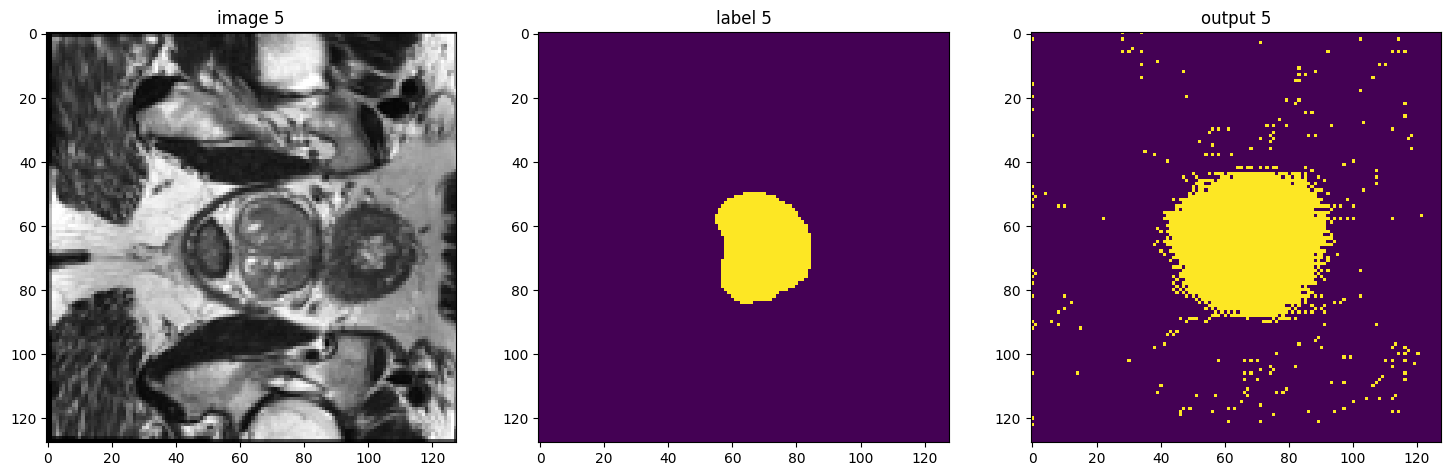

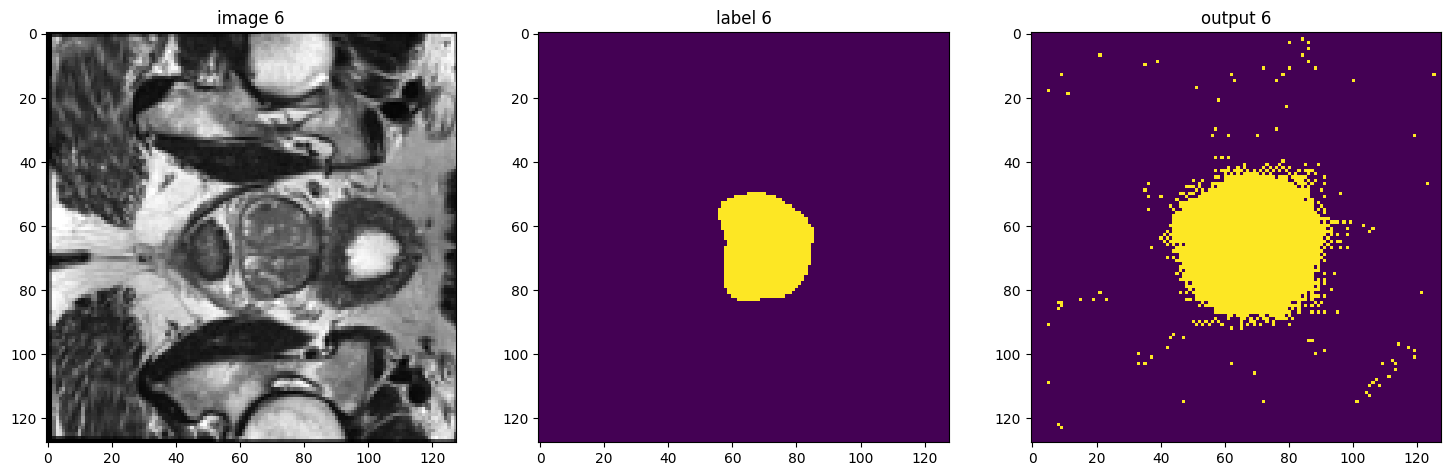

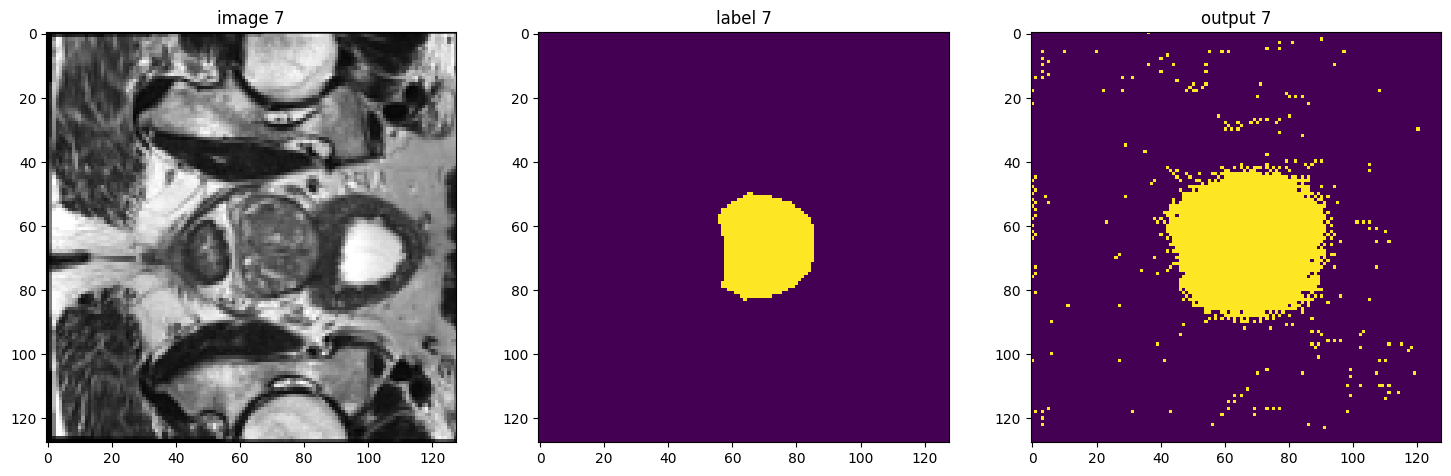

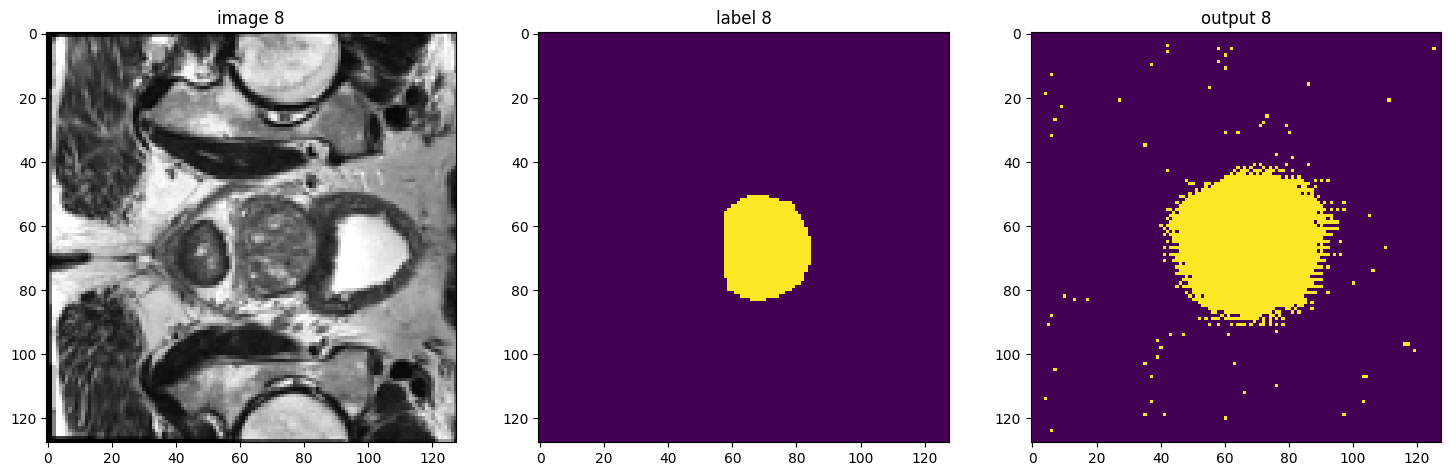

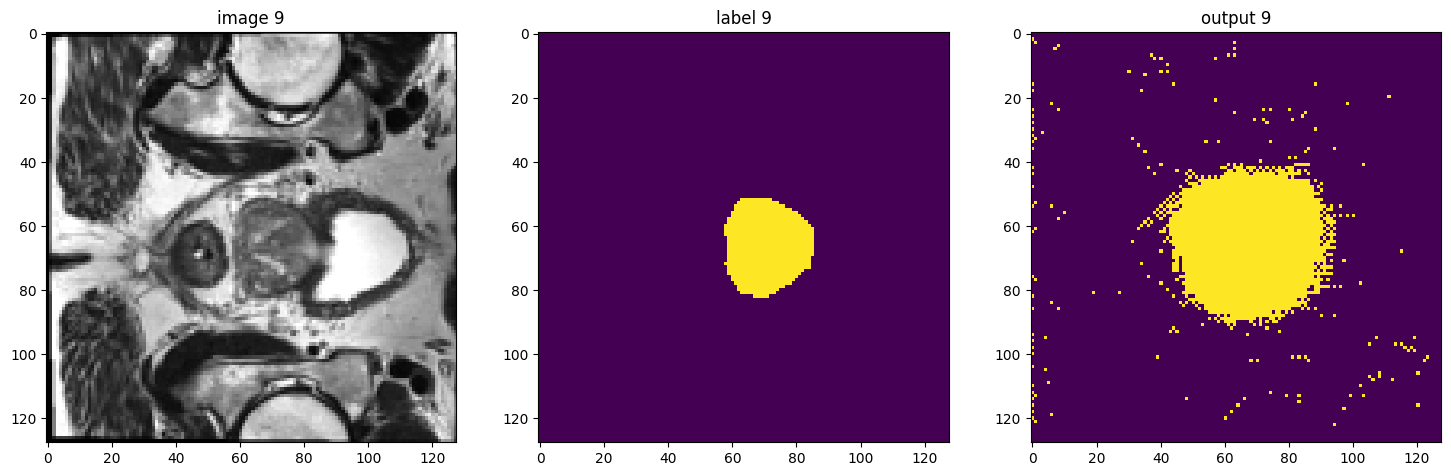

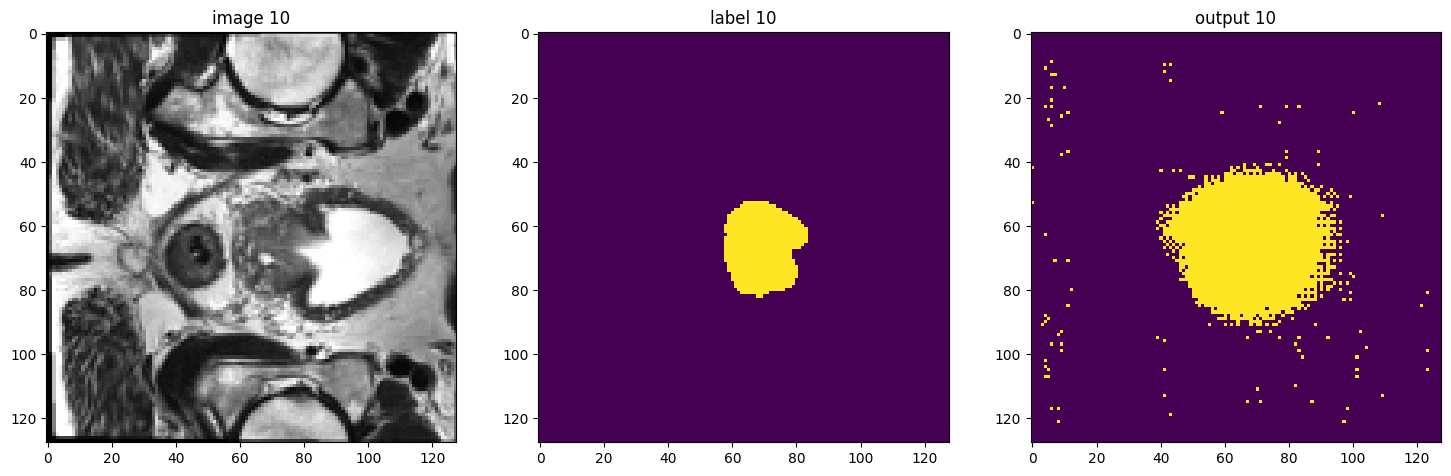

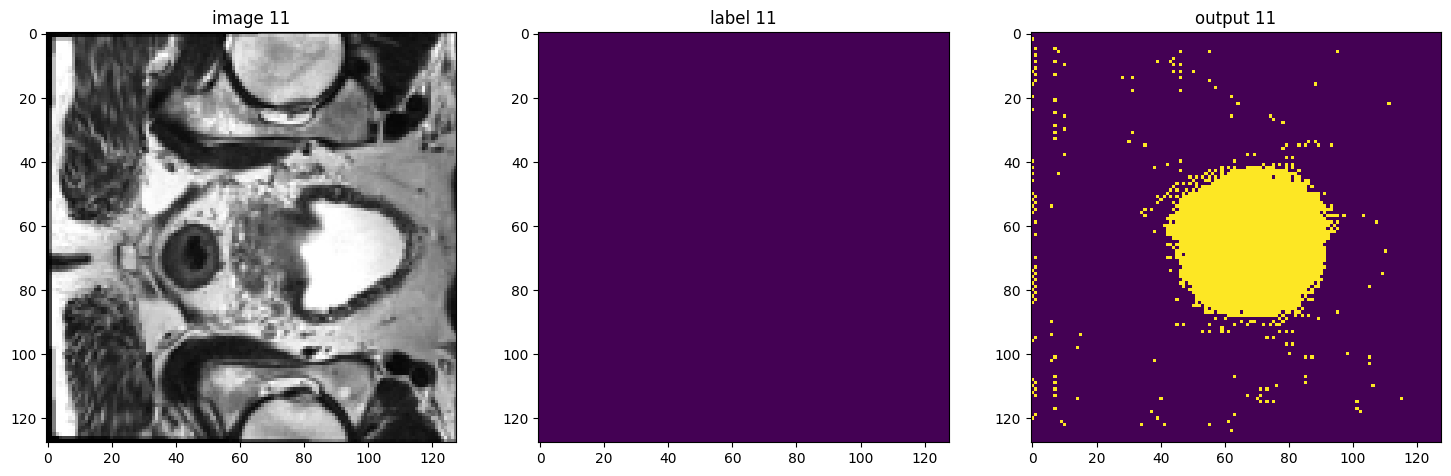

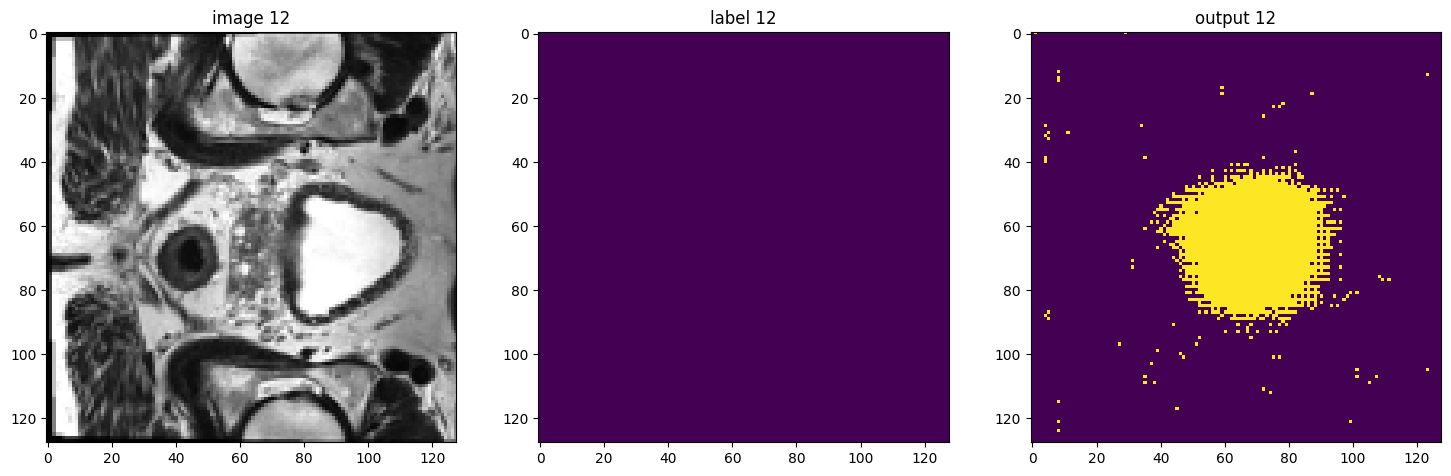

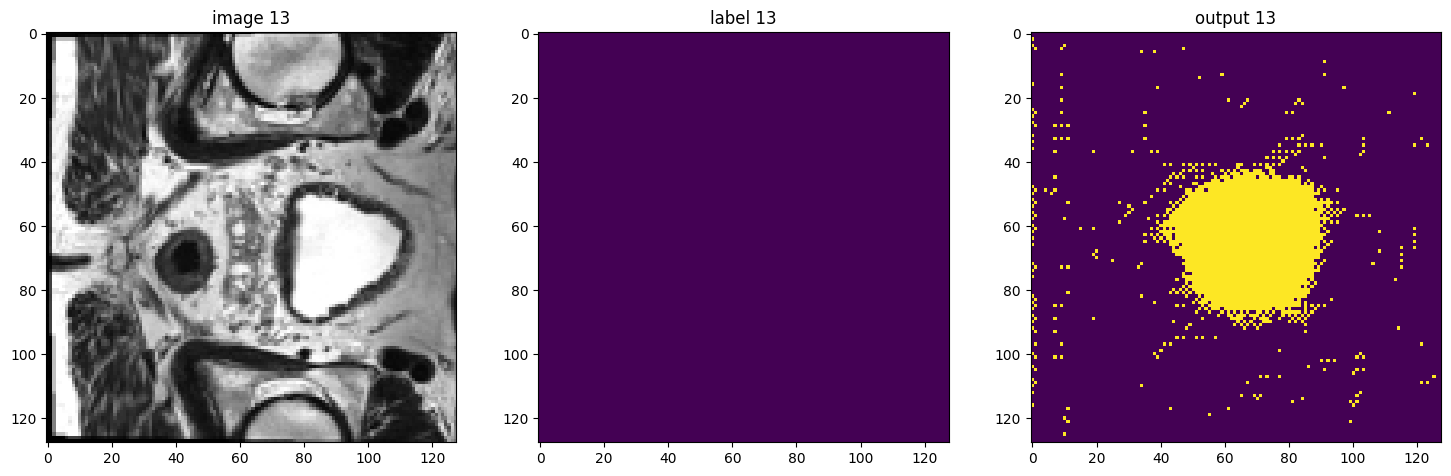

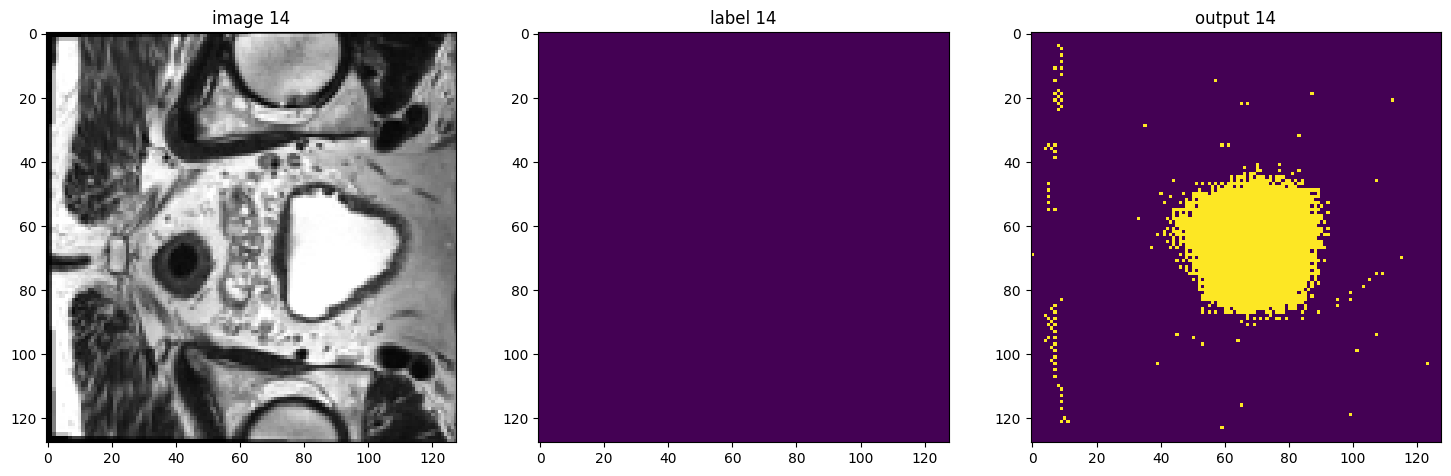

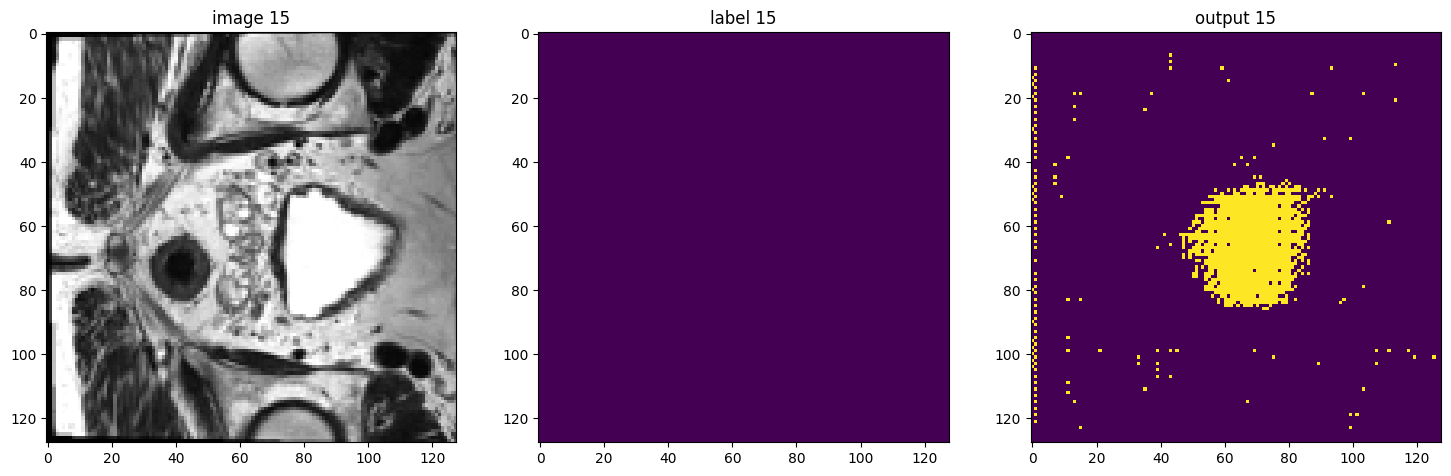

In [54]:
sw_batch_size = 4
roi_size = spatial_size
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(spatial_size[2]):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()